<a href="https://colab.research.google.com/github/taheritajar/experts-group/blob/main/experts_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Person-Car Detection using YoloV3 TF2 GPU Colab Notebook by Taheri

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!git clone https://github.com/taheritajar/experts-group
%cd experts-group/
!pip install -r requirements-gpu.txt

Cloning into 'experts-group'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 109 (delta 48), reused 76 (delta 23), pack-reused 0
Receiving objects: 100% (109/109), 14.25 MiB | 44.61 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/experts-group
Obtaining file:///content/experts-group (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.7MB 44kB/s 
     |████████████████████████████████| 28.7MB 108kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Running setup.py develop for yolov3-tf2


##### 2.  Check Tensorflow2 version

In [2]:
!ls

import tensorflow as tf
tf.__version__

conda-cpu.yml	 docs			    requirements.txt
conda-gpu.yml	 expert-dataset.rar	    setup.py
convert.py	 experts_group_colab.ipynb  tools
data		 LICENSE		    train.py
detect.py	 README.md		    yolov3_tf2
detect_video.py  requirements-gpu.txt	    yolov3_tf2.egg-info


'2.4.0'

##### 3.  Convert Pretrained Darknet Weight

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-01-18 16:11:35--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   741KB/s    in 6m 57s  

2021-01-18 16:18:32 (581 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-01-18 16:18:32.497225: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 16:18:32.497278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-18 16:18:34.136204: I tensorflow/compiler/jit/xla_cpu_device.cc:41]

In [ ]:
!pwd

/content/experts-group


##### 4. Initialize Detector

In [4]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I0118 16:19:19.370575 140035226908544 <ipython-input-5-8266b2c611f7>:9] weights loaded
I0118 16:19:19.373359 140035226908544 <ipython-input-5-8266b2c611f7>:12] classes loaded
I0118 16:19:20.517049 140035226908544 <ipython-input-5-8266b2c611f7>:23] time: 1.112292766571045
I0118 16:19:20.517984 140035226908544 <ipython-input-5-8266b2c611f7>:25] detections:
I0118 16:19:20.524717 140035226908544 <ipython-input-5-8266b2c611f7>:29] 	car, 0.9966800808906555, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0118 16:19:20.528562 140035226908544 <ipython-input-5-8266b2c611f7>:29] 	bus, 0.9952293038368225, [0.32288754 0.15145975 0.6138201  0.506682  ]
I0118 16:19:20.532290 140035226908544 <ipython-input-5-8266b2c611f7>:29] 	bus, 0.9951197504997253, [0.67014587 0.17855005 0.9937171  0.5290145 ]
I0118 16:19:20.536274 140035226908544 <ipython-input-5-8266b2c611f7>:29] 	person, 0.9875381588935852, [0.6138847  0.34505445 0.68770576 0.77529997]
I0118 16:19:20.539190 140035226908544 <ipython-input-5-8266b

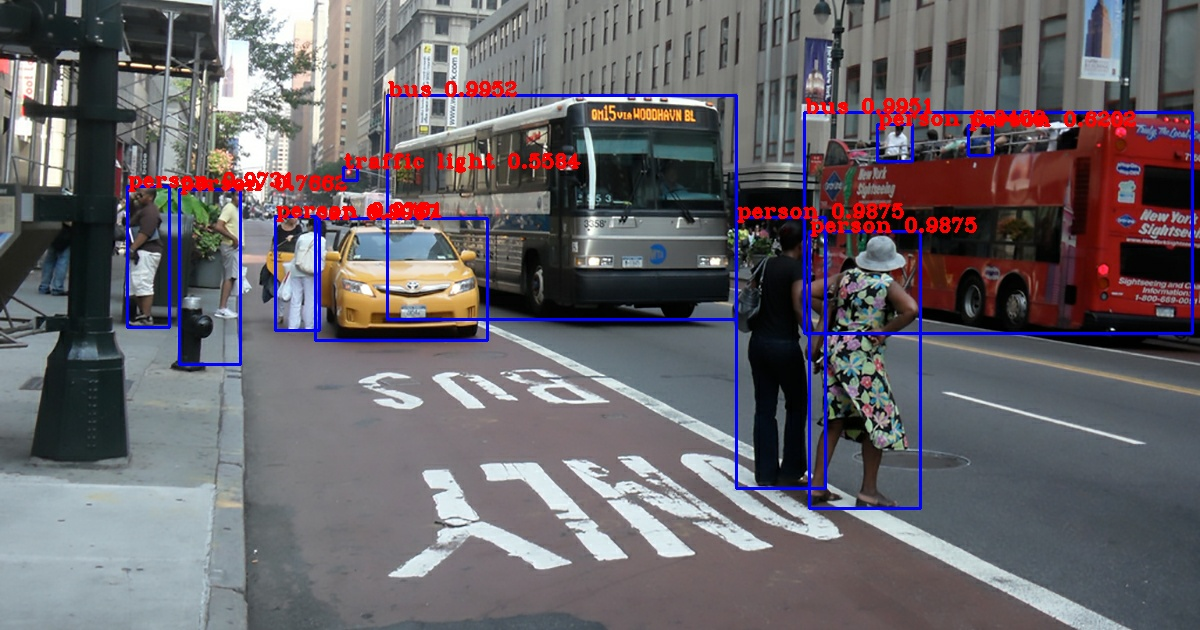

In [5]:
FLAGS.image = 'data/street.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [6]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
# !mkdir -p ./data/voc2009_raw
# !tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw
!unrar x "./expert-dataset.rar" "./dataset/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./expert-dataset.rar

Creating    ./dataset                                                 OK
Creating    ./dataset/test                                            OK
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_107.jpg       0%  1%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_107.xml       1%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_217.jpg       1%  2%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_217.xml       2%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_241.jpg       3%  OK 
Extracting  ./dataset/test/13_Interview_Interview_2_People_Visible_13_241.xml       3%  OK 
Extracting  ./dataset/test/1_Handshaking_Handshaking_1_107.jpg             3%  4%  OK 
Extracting  ./dataset/tes

In [ ]:
!pwd

/content/experts-group/dataset


In [8]:
!python tools/voc2012.py \
  --data_dir './dataset/train' \
  --split train \
  --classes './data/expert.names' \
  --output_file ./data/expert_train.tfrecord

!python tools/voc2012.py \
  --data_dir './dataset/val' \
  --split val \
  --classes './data/expert.names' \
  --output_file ./data/expert_val.tfrecord

2021-01-18 16:21:27.721345: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 16:21:27.721387: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
I0118 16:21:29.457245 139739924273024 voc2012.py:116] Class mapping loaded: {'person': 0, 'car': 1}
I0118 16:21:29.457644 139739924273024 voc2012.py:121] Image list loaded: 28
100% 28/28 [00:00<00:00, 830.68it/s]
I0118 16:21:29.493888 139739924273024 voc2012.py:130] Done
2021-01-18 16:21:30.041558: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 16:21:30.041599: I tensorfl

In [9]:
!python tools/visualize_dataset.py --dataset ./data/expert_train.tfrecord --classes=./data/expert.names

2021-01-18 16:21:42.922092: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 16:21:42.922134: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
I0118 16:21:44.475826 140287521257344 visualize_dataset.py:24] classes loaded
2021-01-18 16:21:44.476207: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-18 16:21:44.477131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-18 16:21:44.482829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

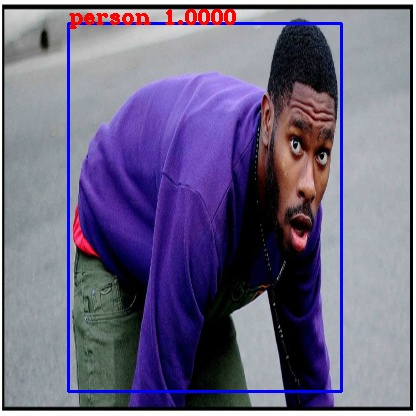

In [10]:
from IPython.display import Image
Image(filename='./output.jpg')

In [11]:
!python train.py \
	--dataset ./data/expert_train.tfrecord \
	--val_dataset ./data/expert_val.tfrecord \
	--classes ./data/expert.names \
	--num_classes 2 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 4 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-01-18 16:22:13.337937: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-18 16:22:13.337979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-01-18 16:22:15.003991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-18 16:22:15.004909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-18 16:22:15.013737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-18 16:22:15.014341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

##### 6. Detect using new weights

I0118 16:28:55.488346 140035226908544 <ipython-input-17-8562ec252053>:16] weights loaded
I0118 16:28:55.490844 140035226908544 <ipython-input-17-8562ec252053>:19] classes loaded
I0118 16:28:56.589685 140035226908544 <ipython-input-17-8562ec252053>:29] time: 1.0830967426300049
I0118 16:28:56.590556 140035226908544 <ipython-input-17-8562ec252053>:31] detections:
I0118 16:28:56.593672 140035226908544 <ipython-input-17-8562ec252053>:35] 	car, 0.9999990463256836, [0.         0.40384606 1.         0.40384623]
I0118 16:28:56.596850 140035226908544 <ipython-input-17-8562ec252053>:35] 	car, 0.9999990463256836, [0.        0.403846  1.        0.4038463]
I0118 16:28:56.599709 140035226908544 <ipython-input-17-8562ec252053>:35] 	car, 0.9999989867210388, [0.         0.42307675 1.         0.4230771 ]
I0118 16:28:56.602569 140035226908544 <ipython-input-17-8562ec252053>:35] 	car, 0.9999989867210388, [0.         0.42307654 1.         0.42307732]
I0118 16:28:56.608639 140035226908544 <ipython-input-17-8

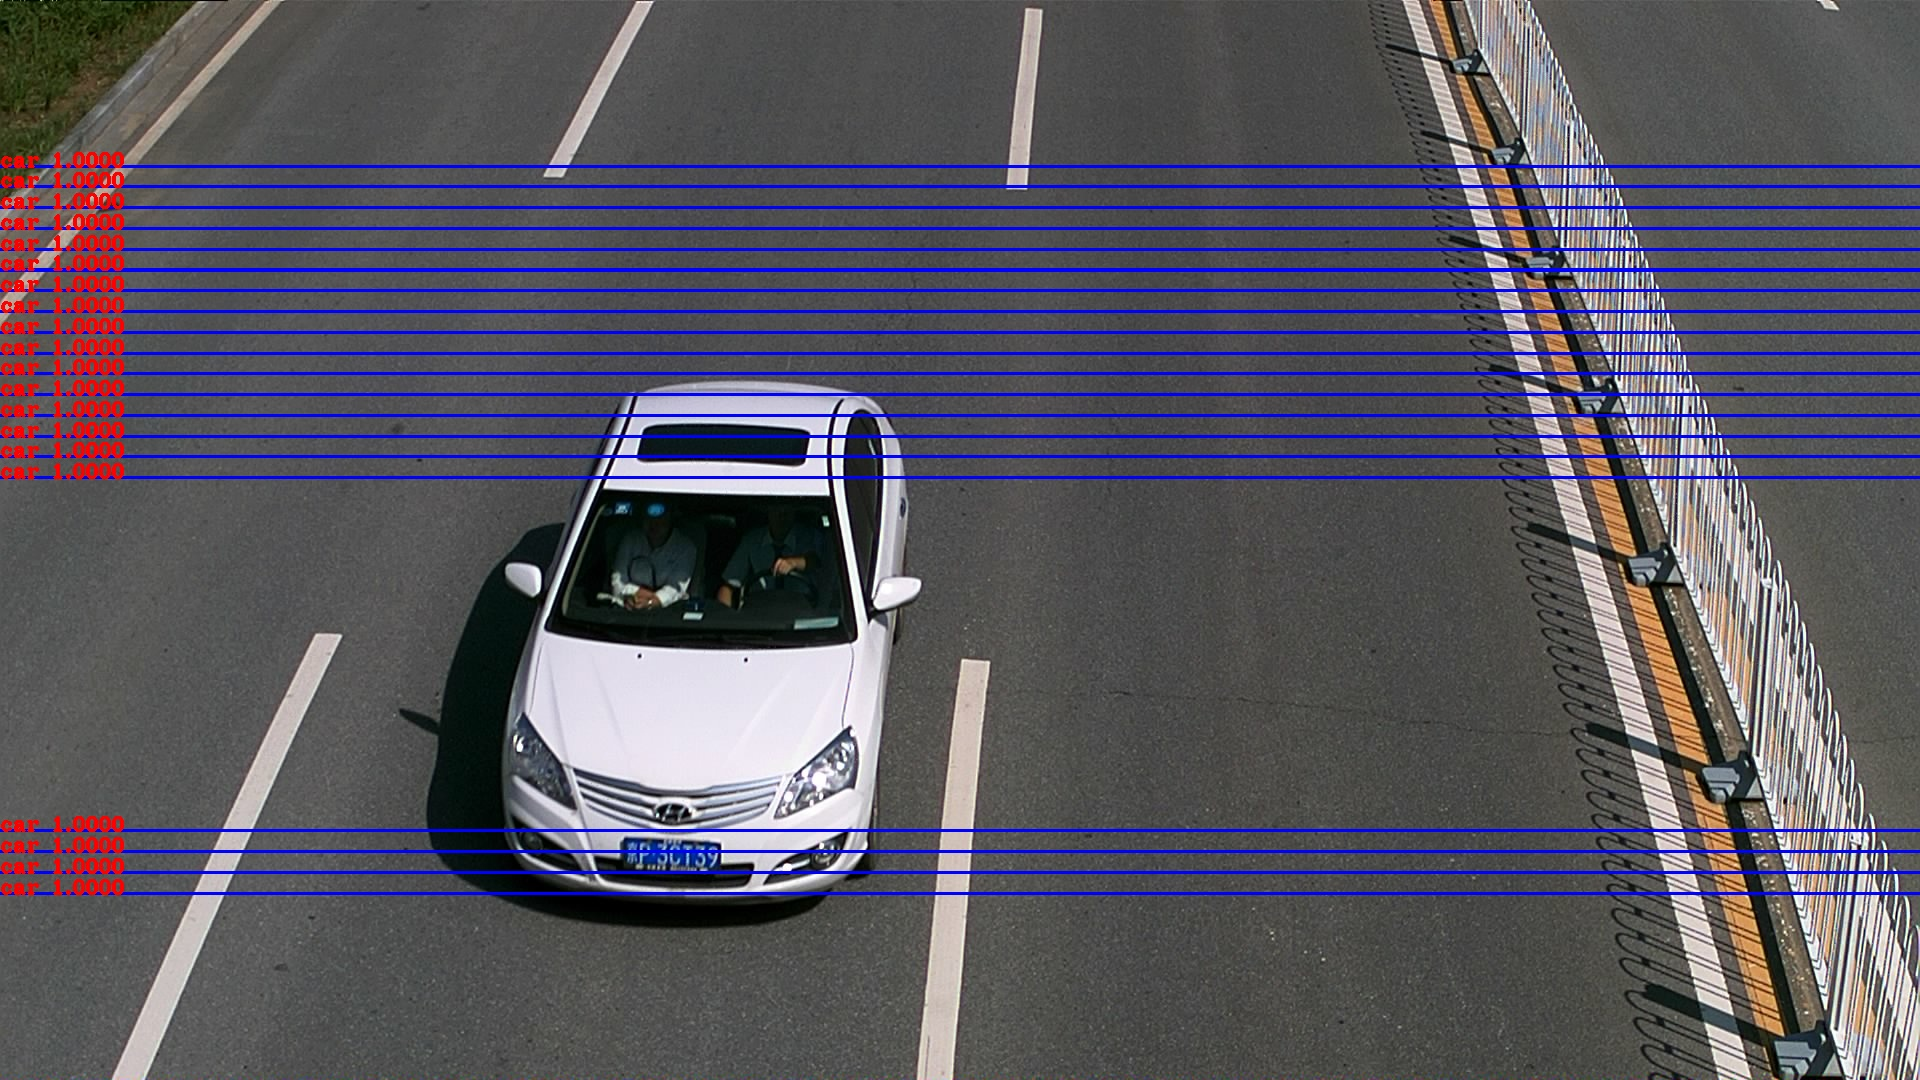

In [17]:
FLAGS.num_classes = 2
FLAGS.classes = './data/expert.names'
FLAGS.weights = 'checkpoints/yolov3_train_4.tf'
FLAGS.image = './dataset/test/vehicle_0000199.jpg'  

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.99
FLAGS.yolo_score_threshold = 0.9999

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))